# Problem Statement

Fradulent Medicare claims is a serious problem impacting the healthcare industry. The purpose of this project is to build a predictive model to detect such claims and help insurance companies to act on those.

# Project Structure

- Data Understading
- Data Prepration
- Exploratory Data Analysis & Feature Engineering
- Modelling
- Model Evaluation
- Deployment

# Data Understanding

As a first step, all sample files will be imported into data frames and preliminary analysis is done.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize":(15, 10)})

In [64]:
file_path="./fraud_data"
in_patient=f"{file_path}/Train_Inpatientdata-1542865627584.csv"
out_patient=f"{file_path}/Train_Outpatientdata-1542865627584.csv"
bene=f"{file_path}/Train_Beneficiarydata-1542865627584.csv"
labelled=f"{file_path}/Train-1542865627584.csv"

In [65]:
df_in = pd.read_csv(in_patient)
df_out = pd.read_csv(out_patient)
df_bene = pd.read_csv(bene)
df_lab = pd.read_csv(labelled)

# Data Preparation

**Inpatient data**

Convert column datatypes to appropriate data types

In [66]:
df_in['ClaimStartDt'] = pd.to_datetime(df_in['ClaimStartDt'], infer_datetime_format=True)
df_in['ClaimEndDt'] = pd.to_datetime(df_in['ClaimEndDt'], infer_datetime_format=True)

In [67]:
# df_in['AttendingPhysician'] = df_in['AttendingPhysician'].astype(pd.StringDtype())

# not-working
for col in df_in.columns: 
    if df_in[col].dtype == 'object':
        df_in[col] = df_in[col].astype('str')

In [68]:
df_in = df_in.merge(df_lab, how='left', left_on='Provider', right_on='Provider', suffixes=('_left', '_right'))

In [69]:
df_in['isFraud'] = df_in['PotentialFraud'].map({'Yes': 1, 'No': 0})

In [90]:
df_in_corr = df_in.loc[:, ['InscClaimAmtReimbursed',
                              'ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3',
                              'ClmProcedureCode_4','ClmProcedureCode_5', 'isFraud']
                             ].corr()
df_in_corr = round(df_in_corr.corr(), 2)

<AxesSubplot:>

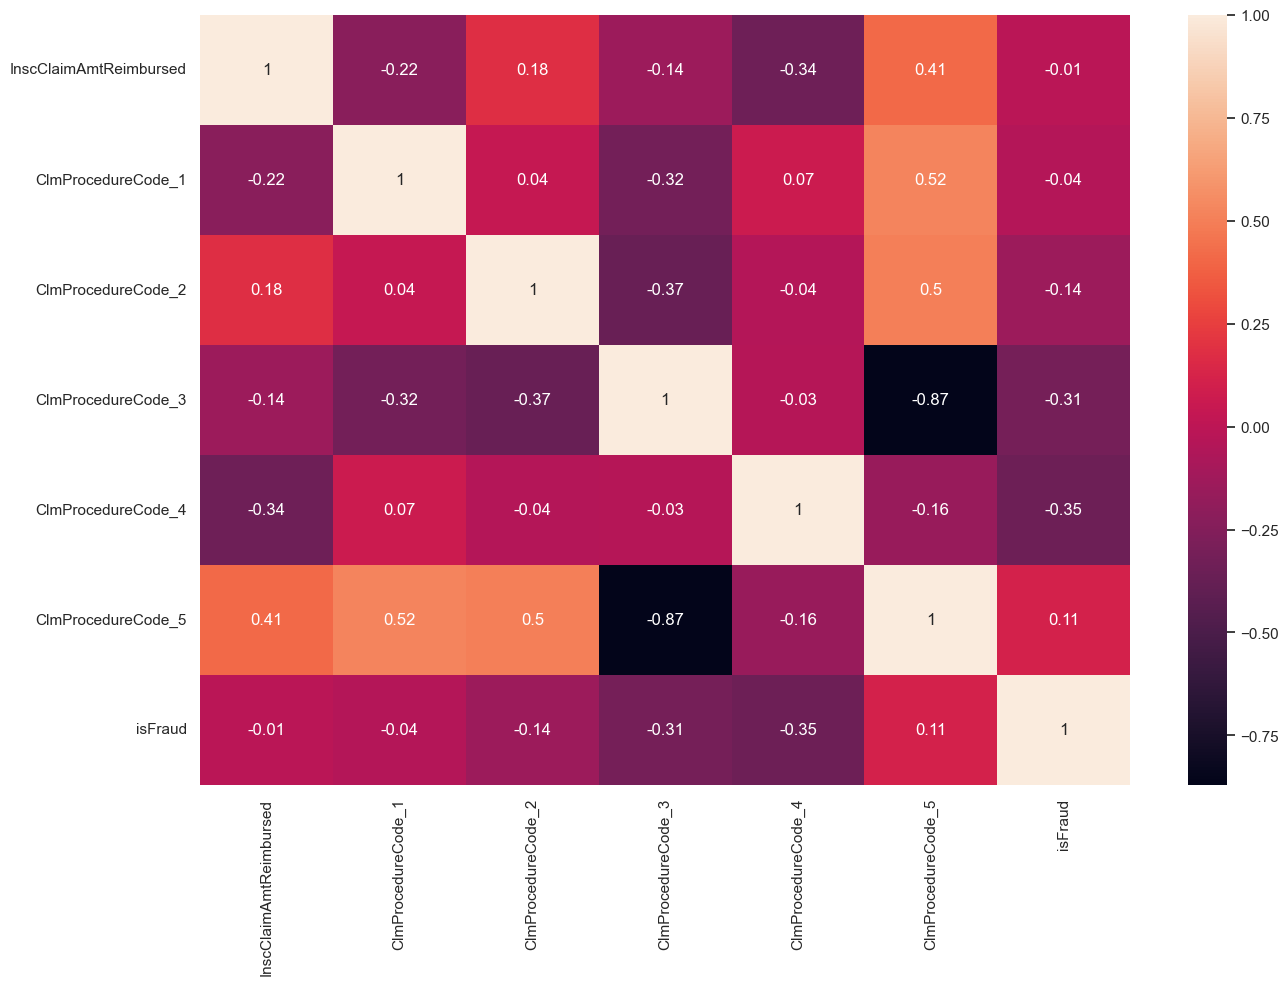

In [91]:
sns.heatmap(df_in_corr, annot=True)

**Outpatient data**

In [72]:
df_out_corr = df_out.loc[:, ['InscClaimAmtReimbursed', 'DeductibleAmtPaid',
                              'ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3',
                              'ClmProcedureCode_4']
                             ].corr()
# df_out_corr

In [73]:
df_out = df_out.merge(df_lab, how='left', left_on='Provider', right_on='Provider', suffixes=('_left', '_right'))

In [74]:
df_out['isFraud'] = df_out['PotentialFraud'].map({'Yes': 1, 'No': 0})

In [75]:
df_out_corr = df_out.loc[:, ['InscClaimAmtReimbursed', 'DeductibleAmtPaid',
                              'ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3',
                              'ClmProcedureCode_4', 'isFraud']
                             ].corr()
df_out_corr = round(df_out_corr, 2)

<AxesSubplot:>

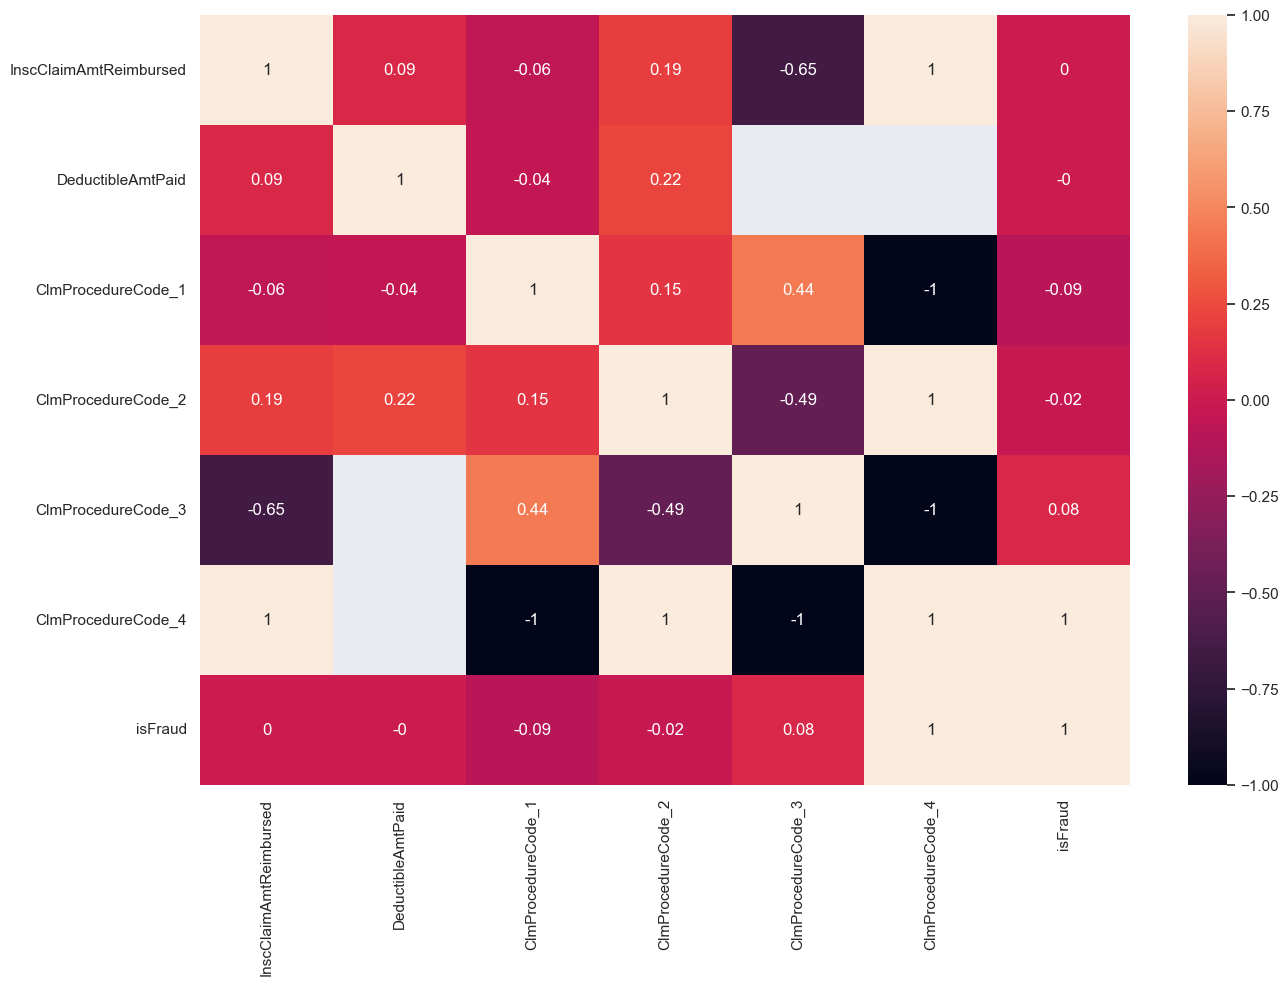

In [76]:
sns.heatmap(df_out_corr, annot=True)

**Beneficiary data**

In [77]:
df_bene['DOB'] = pd.to_datetime(df_bene['DOB'], format = '%Y-%m-%d')
df_bene['DOD'] = pd.to_datetime(df_bene['DOD'], format = '%Y-%m-%d')

***Age***

The max DOD date is 2009-01-12. This is used to fillin NaN values to cacluate age of beneficiary.

In [78]:
df_bene['DOD'].fillna("2009-12-01", inplace=True)
df_bene['Age'] = df_bene['DOD'].dt.year - df_bene['DOB'].dt.year

In [112]:
df_in_new = df_in[['BeneID', 'Provider', 'isFraud']]

In [113]:
df_bene_new = df_bene.merge(df_in_new, how='left', left_on='BeneID', right_on='BeneID', suffixes=('_left', '_right'))

In [117]:
df_bene_corr = round(df_bene_new.corr(), 1)

<AxesSubplot:>

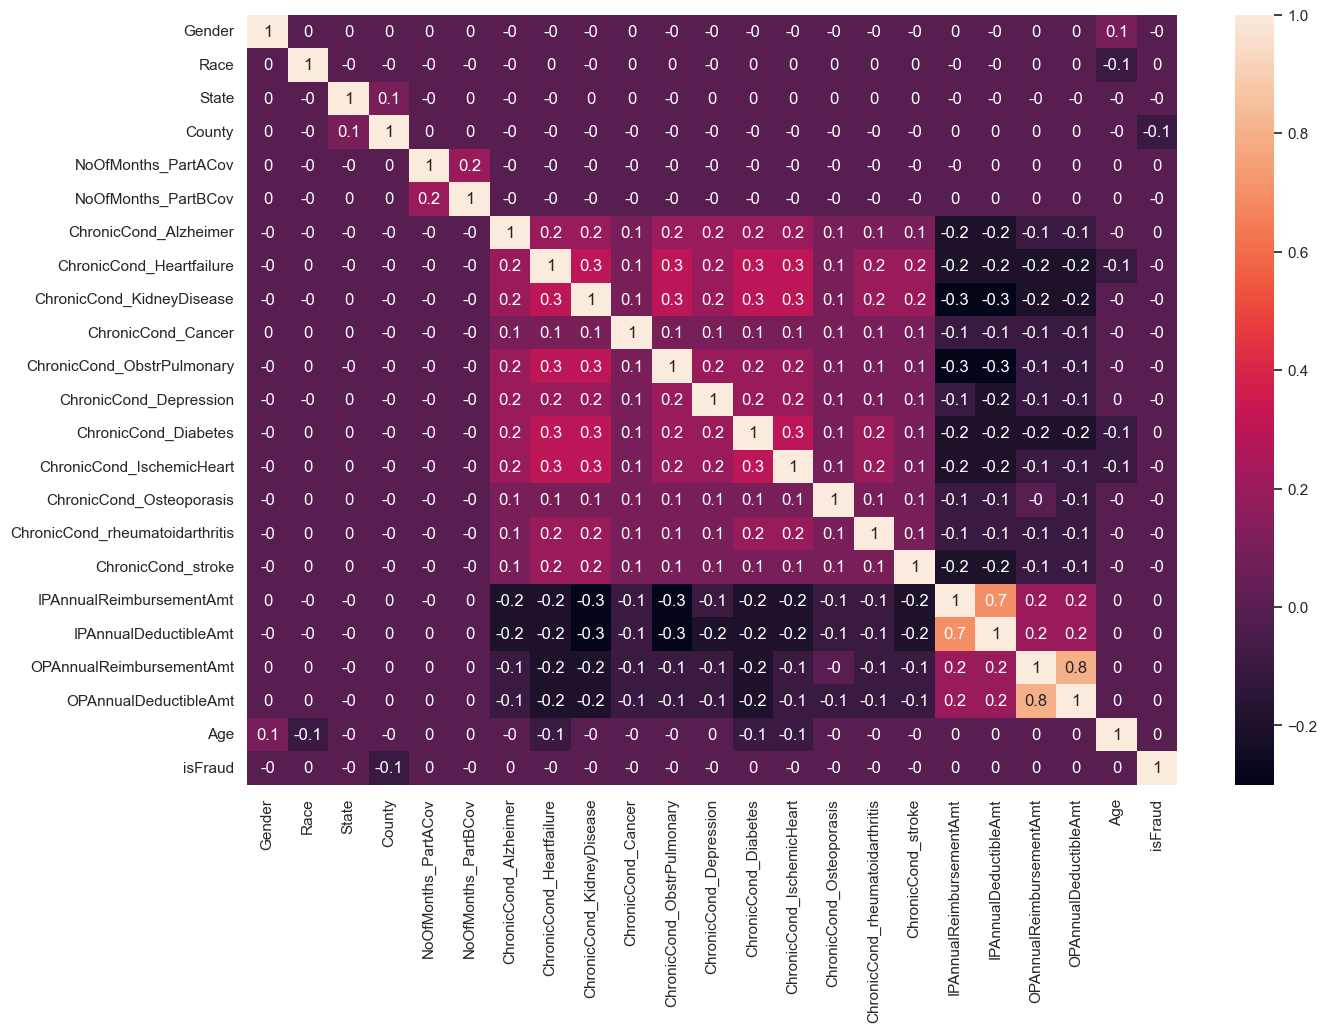

In [118]:
sns.heatmap(df_bene_corr, annot=True)

In [81]:
bene_age_tier = [
    (df_bene['Age'] <= 30),
    (df_bene['Age'] > 30) & (df_bene['Age'] <= 45),
    (df_bene['Age'] > 45) & (df_bene['Age'] <= 64),
    (df_bene['Age'] >= 65)
    ]

In [82]:
bene_age = df_bene['Age']
bene_age = np.select(bene_age_tier, ['Young', 'Early middle' ,'Late middle', 'Senior'])

<AxesSubplot:ylabel='count'>

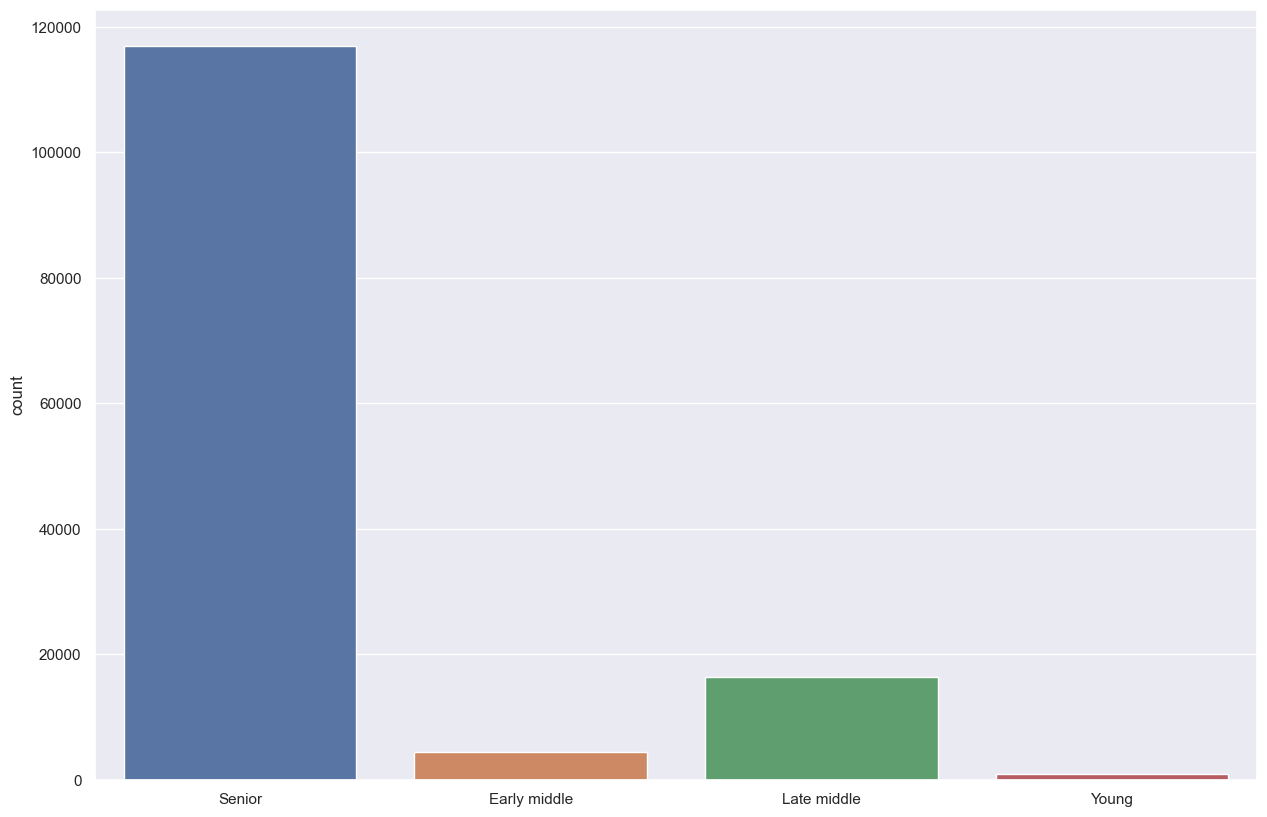

In [83]:
sns.countplot(x=bene_age)

# Exploratory Data Analysis

**Target Labels**

The target variable in the labelled dataset is "PotentialFraud" which indicates whether a provider is fradulent or not. Out of 5410 providers in total, 9.35% are fradulent.

<AxesSubplot:ylabel='PotentialFraud'>

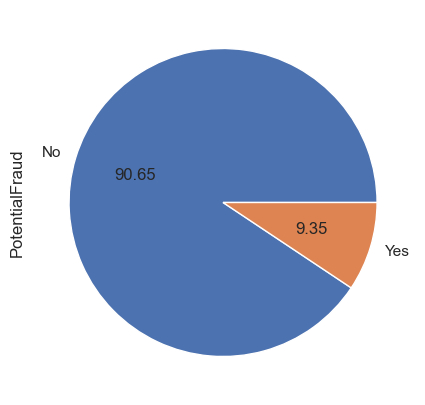

In [84]:
target = df_lab["PotentialFraud"]
target.value_counts().plot.pie(autopct='%.2f',figsize=(6, 5))

# Modeling